### Saving and loading models

This will be incredibly useful because you'll want to load previously trained models to use in making predictions or

In [13]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

import helper

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [14]:
# define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download and load training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

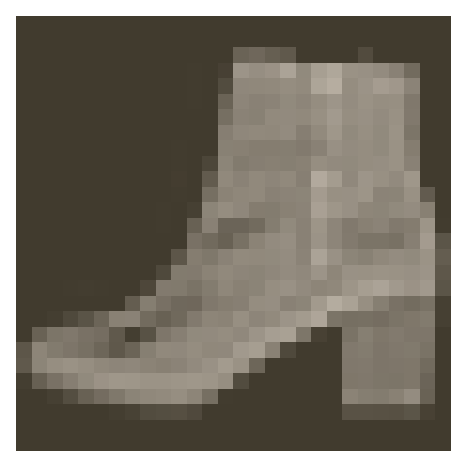

In [15]:
# sample image
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

### Train a network

In [19]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # flatten input tensor
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1) # no dropout on output
        
        return x

In [21]:
model = Classifier()
#model.cuda()
images, labels = next(iter(trainloader))
ps = torch.exp(model(images))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 3
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        #images.cuda()
        #labels.cuda()
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    else:
        test_loss = 0
        accuracy = 0
        
        # turn off gradients for validation to save memory and computation
        with torch.no_grad():
            model.eval() # turns off dropout
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train() # turns dropout back on
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}.. ".format(accuracy/len(testloader)))

Epoch: 1/3..  Training Loss: 0.603..  Test Loss: 0.484..  Test Accuracy: 0.830.. 
Epoch: 2/3..  Training Loss: 0.481..  Test Loss: 0.447..  Test Accuracy: 0.840.. 
Epoch: 3/3..  Training Loss: 0.454..  Test Loss: 0.420..  Test Accuracy: 0.848.. 


Now that we don't want to train the model every time we need to use it, we can save the trained network for later loading.

In [22]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


The parameters for PyTorch networks are stored in the model's state_dict. Above you'll see the weight and bias matrices for each of the layers. Now, save the state dict

In [23]:
torch.save(model.state_dict(), 'checkpoint.pth')

This state dict can then be loaded:

In [24]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


To load the state dict into the network:

In [25]:
model.load_state_dict(state_dict)

Keep in mind some requirements:
Loading the state dict only works if the model architecture is the same as the checkpoint architecture.

In [28]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

AttributeError: 'Classifier' object has no attribute 'hidden_layers'